In [1]:
import numpy as np

In [2]:
history = np.load('save/training_history_WGANVGG.npy', allow_pickle=True).item()

In [3]:
print(len(history))
print(history.keys())


4
dict_keys(['g_minus_p_loss', 'p_loss', 'd_minus_gp_loss', 'gp_loss'])


history keys :  dict_keys(['g_minus_p_loss', 'p_loss', 'd_minus_gp_loss', 'gp_loss'])


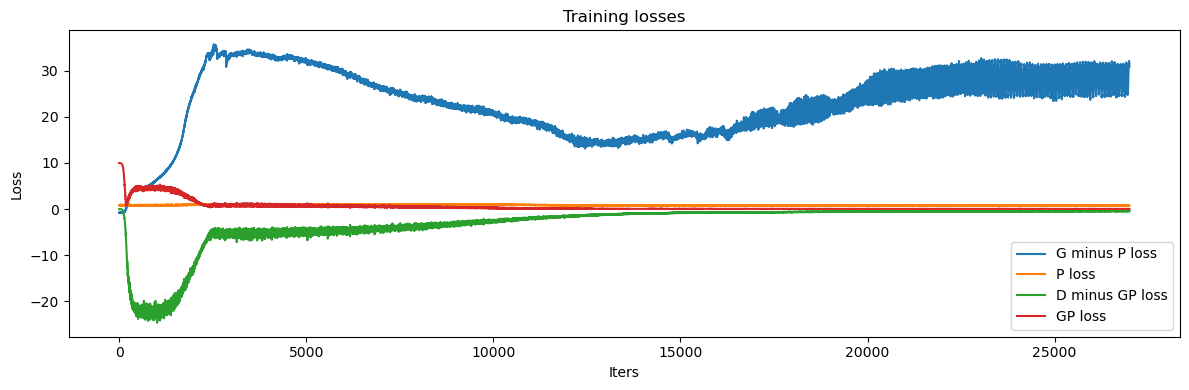

In [4]:
def view_model_history(history):
    # Visualize model history.
    print('history keys : ', history.keys())

    # Plot loss, accuracy, val_loss and val_accuracy

    # Get the number of epochs
    num_iters = 27000

    import matplotlib.pyplot as plt
    
    # Plot training and validation accuracy / PSNR values
    if True:
        plt.figure(figsize=(12, 4))
        #plt.subplot(1, 2, 1)
        plt.plot(range(1, num_iters + 1), history['g_minus_p_loss'], label='G minus P loss')
        plt.plot(range(1, num_iters + 1), history['p_loss'], label='P loss')
        plt.plot(range(1, num_iters + 1), history['d_minus_gp_loss'], label='D minus GP loss')
        plt.plot(range(1, num_iters + 1), history['gp_loss'], label='GP loss')
        plt.title('Training losses')
        plt.xlabel('Iters')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()
    
view_model_history(history)

In [5]:
import os
import time
%matplotlib inline 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim

from prep import printProgressBar
from networks import WGAN_VGG, WGAN_VGG_generator
from metric import compute_measure


class Solver(object):
    def __init__(self, args, data_loader):
        print('solver created')
        self.mode = args.mode
        self.load_mode = args.load_mode
        self.data_loader = data_loader

        if args.device:
            self.device = torch.device(args.device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.norm_range_min = args.norm_range_min
        self.norm_range_max = args.norm_range_max
        self.trunc_min = args.trunc_min
        self.trunc_max = args.trunc_max

        self.save_path = args.save_path
        self.multi_gpu = args.multi_gpu

        self.num_epochs = args.num_epochs
        self.print_iters = args.print_iters
        self.decay_iters = args.decay_iters
        self.save_iters = args.save_iters
        self.test_iters = args.test_iters
        self.result_fig = args.result_fig

        self.n_d_train = args.n_d_train

        self.patch_n = args.patch_n
        self.batch_size = args.batch_size
        self.patch_size = args.patch_size

        self.lr = args.lr
        self.lambda_ = args.lambda_

        self.WGANVGG = WGAN_VGG(input_size=args.patch_size if args.patch_n else 512)

        if (self.multi_gpu) and (torch.cuda.device_count() > 1):
            print('Use {} GPUs'.format(torch.cuda.device_count()))
            self.WGANVGG = nn.DataParallel(self.WGANVGG)

        self.WGANVGG.to(self.device)

        self.criterion_perceptual = nn.L1Loss()
        self.optimizer_g = optim.Adam(self.WGANVGG.generator.parameters(), self.lr)
        self.optimizer_d = optim.Adam(self.WGANVGG.discriminator.parameters(), self.lr)


    def save_model(self, iter_, loss_=None):
        f = os.path.join(self.save_path, 'WGANVGG_{}iter.ckpt'.format(iter_))
        torch.save(self.WGANVGG.state_dict(), f)
        if loss_:
            f_loss = os.path.join(self.save_path, 'WGANVGG_loss_{}iter.npy'.format(iter_))
            np.save(f_loss, np.array(loss_))


    def load_model(self, iter_):
        print('loading model...')
        print('WGANVGG_{}iter.ckpt'.format(iter_))
        f = os.path.join(self.save_path, 'WGANVGG_{}iter.ckpt'.format(iter_))
        print('found path of ckpt')
        generator_w = {k[10:]:torch.load(f)[k] for k in  list(torch.load(f).keys()) if 'generator' in k}
        
        if self.multi_gpu:
            state_d = OrderedDict()
            for k, v in generator_w:
                n = k[7:]
                state_d[n] = v
            self.WGANVGG_G.load_state_dict(state_d)
        else:
            self.WGANVGG_G.load_state_dict(generator_w)


    def lr_decay(self):
        lr = self.lr * 0.5
        for param_group in self.optimizer_g.param_groups:
            param_group['lr'] = lr
        for param_group in self.optimizer_d.param_groups:
            param_group['lr'] = lr


    def denormalize_(self, image):
        image = image * (self.norm_range_max - self.norm_range_min) + self.norm_range_min
        return image


    def trunc(self, mat):
        mat[mat <= self.trunc_min] = self.trunc_min
        mat[mat >= self.trunc_max] = self.trunc_max
        return mat


    def save_fig(self, x, y, pred, fig_name, original_result, pred_result):
        x, y, pred = x.numpy(), y.numpy(), pred.numpy()
        f, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].imshow(x, cmap=plt.cm.gray, vmin=self.trunc_min, vmax=self.trunc_max)
        ax[0].set_title('Quarter-dose', fontsize=30)
        ax[0].set_xlabel("PSNR: {:.4f}\nSSIM: {:.4f}\nRMSE: {:.4f}".format(original_result[0],
                                                                           original_result[1],
                                                                           original_result[2]), fontsize=20)
        ax[1].imshow(pred, cmap=plt.cm.gray, vmin=self.trunc_min, vmax=self.trunc_max)
        ax[1].set_title('Result', fontsize=30)
        ax[1].set_xlabel("PSNR: {:.4f}\nSSIM: {:.4f}\nRMSE: {:.4f}".format(pred_result[0],
                                                                           pred_result[1],
                                                                           pred_result[2]), fontsize=20)
        ax[2].imshow(y, cmap=plt.cm.gray, vmin=self.trunc_min, vmax=self.trunc_max)
        ax[2].set_title('Full-dose', fontsize=30)

        plt.show()
        #f.savefig(os.path.join(self.save_path, 'fig', 'result_{}.png'.format(fig_name)))
        

    def test(self):
        del self.WGANVGG
        # load
        self.WGANVGG_G = WGAN_VGG_generator().to(self.device)
        self.load_model(self.test_iters)

        # compute PSNR, SSIM, RMSE
        ori_psnr_avg, ori_ssim_avg, ori_rmse_avg = 0, 0, 0
        pred_psnr_avg, pred_ssim_avg, pred_rmse_avg = 0, 0, 0

        with torch.no_grad():
            for i, (x, y) in enumerate(self.data_loader):
                shape_ = x.shape[-1]
                x = x.unsqueeze(0).float().to(self.device)
                y = y.unsqueeze(0).float().to(self.device)

                pred = self.WGANVGG_G(x)

                # denormalize, truncate
                x = self.trunc(self.denormalize_(x.view(shape_, shape_).cpu().detach()))
                y = self.trunc(self.denormalize_(y.view(shape_, shape_).cpu().detach()))
                pred = self.trunc(self.denormalize_(pred.view(shape_, shape_).cpu().detach()))

                data_range = self.trunc_max - self.trunc_min

                original_result, pred_result = compute_measure(x, y, pred, data_range)
                ori_psnr_avg += original_result[0]
                ori_ssim_avg += original_result[1]
                ori_rmse_avg += original_result[2]
                pred_psnr_avg += pred_result[0]
                pred_ssim_avg += pred_result[1]
                pred_rmse_avg += pred_result[2]

                # save result figure
                print('show output : ', self.result_fig)
                if self.result_fig:
                    self.save_fig(x, y, pred, i, original_result, pred_result)

                #printProgressBar(i, len(self.data_loader),
                 #                prefix="Compute measurements ..",
                 #
                 # suffix='Complete', length=25)
            print('\n')
            print('Original\nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nRMSE avg: {:.4f}'.format(ori_psnr_avg/len(self.data_loader), ori_ssim_avg/len(self.data_loader), ori_rmse_avg/len(self.data_loader)))
            print('After learning\nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nRMSE avg: {:.4f}'.format(pred_psnr_avg/len(self.data_loader), pred_ssim_avg/len(self.data_loader), pred_rmse_avg/len(self.data_loader)))



In [6]:
import os
import argparse
from torch.backends import cudnn
from loader import get_loader



def main(args):
    print('in func main')
    cudnn.benchmark = True

    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)
        print('Create path : {}'.format(args.save_path))

    if args.result_fig:
        fig_path = os.path.join(args.save_path, 'fig')
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
            print('Create path : {}'.format(fig_path))

    data_loader = get_loader(mode=args.mode,
                             load_mode=args.load_mode,
                             saved_path=args.saved_path,
                             test_patient=args.test_patient,
                             patch_n=(args.patch_n if args.mode=='train' else None),
                             patch_size=(args.patch_size if args.mode=='train' else None),
                             transform=args.transform,
                             batch_size=(args.batch_size if args.mode=='train' else 1),
                             num_workers=args.num_workers)

    print('creating solver')
    solver = Solver(args, data_loader)
    if args.mode == 'train':
        solver.train()
    elif args.mode == 'test':
        solver.test()


if __name__ == "__main__":
    from types import SimpleNamespace  
    # Hardcoded values
    mode = 'test'
    load_mode = 0
    data_path = './AAPM-Mayo-CT-Challenge/'
    saved_path = './npy_img/'
    save_path = './save/'
    test_patient = 'L506'
    result_fig = True
    norm_range_min = -1024.0
    norm_range_max = 3072.0
    trunc_min = -160.0
    trunc_max = 240.0
    transform = False
    patch_n = 10
    patch_size = 80
    batch_size = 16
    num_epochs = 4
    print_iters = 20
    decay_iters = 3000
    save_iters = 1000
    test_iters = 27000
    n_d_train = 4
    lr = 1e-6
    lambda_ = 10.0
    device = 'cuda'  # Set your desired device
    num_workers = 1
    multi_gpu = False

    # Create a namespace with hardcoded values
    args = SimpleNamespace(
        mode=mode,
        load_mode=load_mode,
        data_path=data_path,
        saved_path=saved_path,
        save_path=save_path,
        test_patient=test_patient,
        result_fig=result_fig,
        norm_range_min=norm_range_min,
        norm_range_max=norm_range_max,
        trunc_min=trunc_min,
        trunc_max=trunc_max,
        transform=transform,
        patch_n=patch_n,
        patch_size=patch_size,
        batch_size=batch_size,
        num_epochs=num_epochs,
        print_iters=print_iters,
        decay_iters=decay_iters,
        save_iters=save_iters,
        test_iters=test_iters,
        n_d_train=n_d_train,
        lr=lr,
        lambda_=lambda_,
        device=device,
        num_workers=num_workers,
        multi_gpu=multi_gpu
    )

    print(args)
    main(args)



namespace(mode='test', load_mode=0, data_path='./AAPM-Mayo-CT-Challenge/', saved_path='./npy_img/', save_path='./save/', test_patient='L506', result_fig=True, norm_range_min=-1024.0, norm_range_max=3072.0, trunc_min=-160.0, trunc_max=240.0, transform=False, patch_n=10, patch_size=80, batch_size=16, num_epochs=4, print_iters=20, decay_iters=3000, save_iters=1000, test_iters=27000, n_d_train=4, lr=1e-06, lambda_=10.0, device='cuda', num_workers=1, multi_gpu=False)
in func main
creating solver
solver created
loading model...
WGANVGG_27000iter.ckpt
found path of ckpt


: 